# Modelling the Relationship Between Programming Language Proficiency and Software Engineer Salaries in the U.S.

This project was completed as part of the COGS108 Final Project.

The dataset was obtained from https://insights.stackoverflow.com/survey (2023 data)

## Research Question

What is the correlation between the number of programming languages an individual possesses and the median salary of software engineers in the United States, and does knowing certain popular languages like Python or Java have a higher effect on one’s salary than knowing unpopular languages? As students going into the software engineering field in the future, we hope to determine what programming languages are best to learn to increase our financial benefits and to predict our future salaries based on the languages.

## Hypothesis


We hypothesize that there is a significant positive correlation between the number of programming languages a software engineer is proficient in and their median salary in the United States because the more languages a software engineer is proficient in, the more capable they are perceived to be in handling diverse challenges, leading to potentially higher job offers. In addition, we hypothesize that knowing languages like Python which are commonly used by many companies over knowing very uncommon languages leads to higher salaries, since companies need to hire people that know the language that their codebase is based on.

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import patsy
import statsmodels.api as sm
import scipy.stats as stats
pd.set_option("display.max_columns", 15)

In [2]:
survey = pd.read_csv('survey_results_public.csv')
survey.head()

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,...,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,...,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,...,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,...,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,...,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


In [3]:
# Removing unnecessary columns and only keeping the salary and programming languages known
# Removing missing data from our columns

filtered_survey = survey[survey['MainBranch']=='I am a developer by profession']
data = filtered_survey[['ConvertedCompYearly', 'LanguageHaveWorkedWith']]
data = data.rename({'ConvertedCompYearly': 'Salary', 'LanguageHaveWorkedWith': 'Languages'}, axis=1)
data = data.dropna().reset_index(drop=True)
data['Languages'] = data['Languages'].str.split(';')
data.head()

,Salary,Languages
0,285000.0,"[HTML/CSS, JavaScript, Python]"
1,250000.0,"[Bash/Shell (all shells), Go]"
2,156000.0,"[Bash/Shell (all shells), HTML/CSS, JavaScript..."
3,23456.0,"[HTML/CSS, JavaScript, TypeScript]"
4,96828.0,"[Bash/Shell (all shells), HTML/CSS, JavaScript..."


In [4]:
# One hot encoding the programming languages and finding the total languages known for every response

languages = pd.get_dummies(data['Languages'].apply(pd.Series).stack()).groupby(level=0).sum()
data['Total_Languages'] = languages.sum(axis=1)
data = pd.concat([data, languages], axis=1).drop(columns=['Languages'])
data.head()

,Salary,Total_Languages,APL,Ada,Apex,Assembly,Bash/Shell (all shells),...,Scala,Solidity,Swift,TypeScript,VBA,Visual Basic (.Net),Zig
0,285000.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0
1,250000.0,2,0,0,0,0,1,...,0,0,0,0,0,0,0
2,156000.0,7,0,0,0,0,1,...,0,0,0,1,0,0,0
3,23456.0,3,0,0,0,0,0,...,0,0,0,1,0,0,0
4,96828.0,6,0,0,0,0,1,...,0,0,0,1,0,0,0


## Exploratory Data Analysis

### Descriptive Analysis

In [5]:
data.shape

(44245, 53)

In [6]:
description = data.describe() 
language_counts = data.iloc[:, 2:].sum() 
description

,Salary,Total_Languages,APL,Ada,Apex,Assembly,Bash/Shell (all shells),...,Scala,Solidity,Swift,TypeScript,VBA,Visual Basic (.Net),Zig
count,4.424500e+04,44245.000000,44245.000000,44245.000000,44245.000000,44245.000000,44245.000000,...,44245.000000,44245.000000,44245.000000,44245.000000,44245.000000,44245.000000,44245.000000
mean,1.036221e+05,5.178144,0.001085,0.005063,0.006080,0.031755,0.338999,...,0.033925,0.011888,0.049203,0.450831,0.027935,0.037790,0.005899
std,7.041697e+05,2.885067,0.032920,0.070973,0.077736,0.175349,0.473375,...,0.181038,0.108385,0.216295,0.497582,0.164790,0.190689,0.076579
min,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.446700e+04,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.496300e+04,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.225000e+05,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,7.435143e+07,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
language_counts.head()

APL                           48
Ada                          224
Apex                         269
Assembly                    1405
Bash/Shell (all shells)    14999
dtype: int64

1. Salary Insights:

    The average salary among the respondents is approximately \\$103,622.10.   
    There's a significant variation in the salary data, indicated by the
large standard deviation of approximately 704,169.70. This could be
due to a wide range of roles, geographical locations, and experience
levels. The salary range is extremely broad, starting as low as \\$1 to a
maximum of over \\$74 million.



2. Programming Language Familiarity:

    On average, respondents are familiar with about 5.18 programming
languages, reflecting a diverse skill set in the tech field. The range
of known languages per respondent varies significantly, from a minimum
of 1 to a maximum of 51. 


3. Usage of Different Languages:

    Popular languages like HTML/CSS and JavaScript show high usage, with
23,137 and 29,090 respondents respectively, confirming their widespread
application in the industry. Python is also notably popular, used by
19,229 respondents, which aligns with its growing demand in various
domains like data science and web development.
Languages like C++, Java, and SQL are also widely used, with thousands
of respondents familiar with them.
In contrast, languages like APL, Ada, and Zig have much lower usage
rates.

    

### Univariate Analysis of Salary

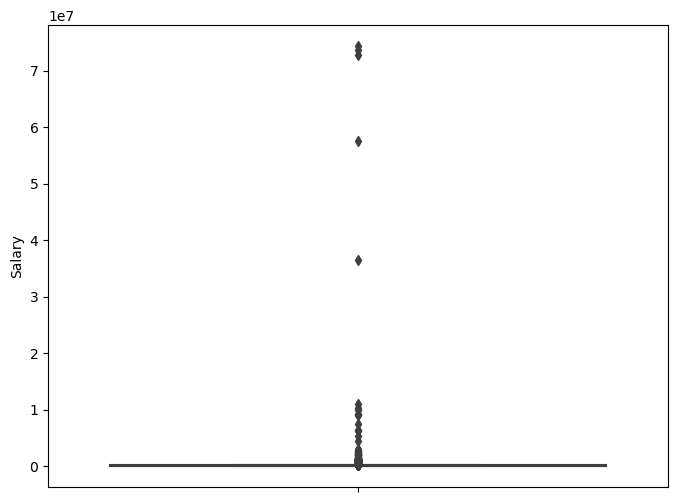

In [8]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(y=data['Salary'])
plt.show()

Based on the graph above, we obtain the following values:
- q1: \$44,467
- q2: \$74,963
- q3: \$122,518.8
- upper fence: \$239,587
- lower fence: \$1

We are going to use the upper fence and lower fence to get rid of the outlier values.

In [9]:
data_no_outlier = data[(data['Salary'] >= 1) & (data['Salary'] <= 239587)]
data_no_outlier.head()

,Salary,Total_Languages,APL,Ada,Apex,Assembly,Bash/Shell (all shells),...,Scala,Solidity,Swift,TypeScript,VBA,Visual Basic (.Net),Zig
2,156000.0,7,0,0,0,0,1,...,0,0,0,1,0,0,0
3,23456.0,3,0,0,0,0,0,...,0,0,0,1,0,0,0
4,96828.0,6,0,0,0,0,1,...,0,0,0,1,0,0,0
5,135000.0,15,0,1,0,0,0,...,1,0,1,1,0,0,1
6,80000.0,7,0,0,0,0,0,...,0,0,0,1,0,0,0


In [10]:
data_no_outlier.shape

(42220, 53)

Now that we got rid of the outlier salaries, we are going to plot the distribution of the salaries.

Text(0, 0.5, 'Density')

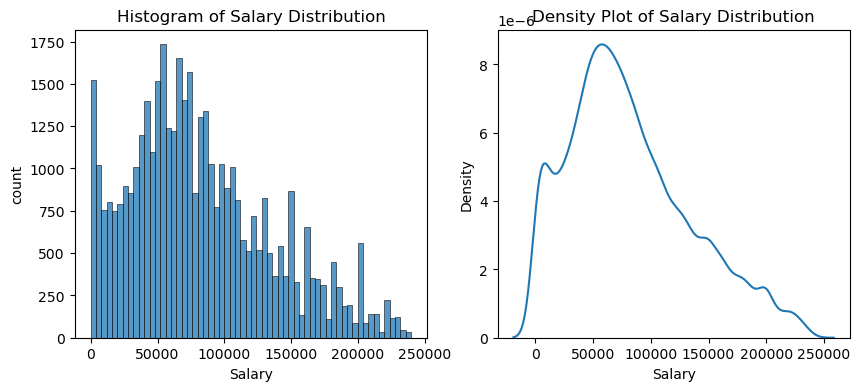

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(data_no_outlier['Salary'], ax=ax[0], kde=False)
ax[0].set_title("Histogram of Salary Distribution")
ax[0].set_xlabel('Salary')
ax[0].set_ylabel('count')

sns.kdeplot(data_no_outlier['Salary'], ax=ax[1])
ax[1].set_title("Density Plot of Salary Distribution")
ax[1].set_xlabel('Salary')
ax[1].set_ylabel('Density')

From the graphs above, we can see that Salary have a shape similar to normal distribution, but is also right-skewed. This suggests that most individuals have salaries that are on the lower bracket, which makes total sense.

### Univariate Analysis of Languages

We are going to use the DataFrame `data_no_outlier` from before which got rid of the outliers.

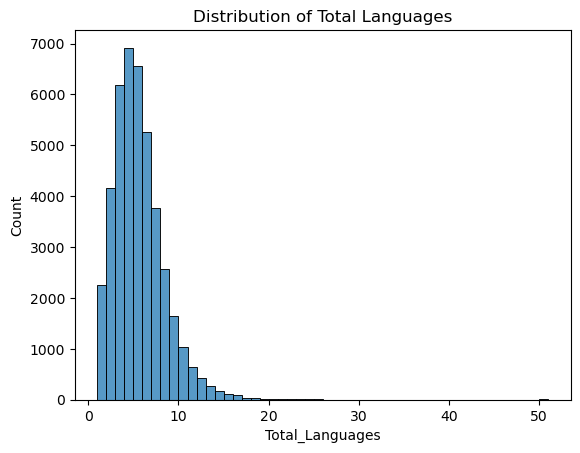

In [12]:
sns.histplot(data=data_no_outlier, x='Total_Languages', bins=50)
plt.title('Distribution of Total Languages')
plt.show()

The graph above is right skewed. However, if we got rid of the outliers, the graph would be roughly normally distributed. Based on the graph, the average number of languages an individual have worked with is 4. This suggests that most individuals have worked with lower number of programming languages which makes total sense as different positions require only several programming languages.

In [13]:
Total_Languages_Count = data_no_outlier['Total_Languages'].value_counts()
Total_Languages_Count.head()

4    6922
5    6562
3    6186
6    5258
2    4154
Name: Total_Languages, dtype: int64

Let's remove the number of total languages that have count < 10.

In [14]:
Total_Languages_Count = Total_Languages_Count[Total_Languages_Count >= 10]
Total_Languages_Count.head()

4    6922
5    6562
3    6186
6    5258
2    4154
Name: Total_Languages, dtype: int64

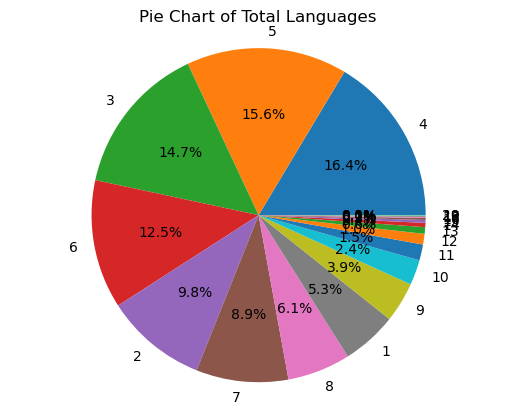

In [15]:
plt.pie(Total_Languages_Count, labels=Total_Languages_Count.index, autopct='%1.1f%%')
plt.title('Pie Chart of Total Languages')
plt.axis('equal')
plt.show()

### Bivariate Analysis of Users per Language

This part will analyze the percentage of users for each language.

In [16]:
userProportions = pd.DataFrame(languages.mean()*100).reset_index()
userProportions.columns = ['Language', 'Percentage']
userProportions = userProportions.sort_values('Percentage', ascending=False).reset_index(drop=True)
userProportions.head()

,Language,Percentage
0,JavaScript,65.747542
1,HTML/CSS,52.292914
2,SQL,52.116623
3,TypeScript,45.083060
4,Python,43.460278


We can plot the percent of individuals who know the 10 most and least popular languages to determine the distribution of users across languages.

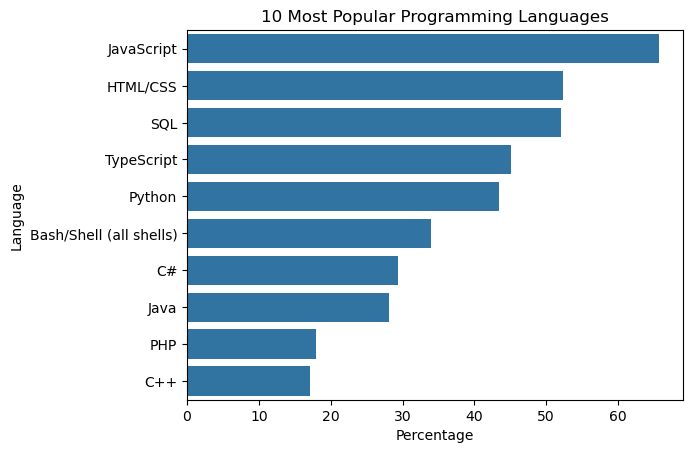

In [17]:
color = sns.color_palette()[0]
sns.barplot(data=userProportions[:10], y='Language', x='Percentage', color=color)
plt.title('10 Most Popular Programming Languages')
plt.show()

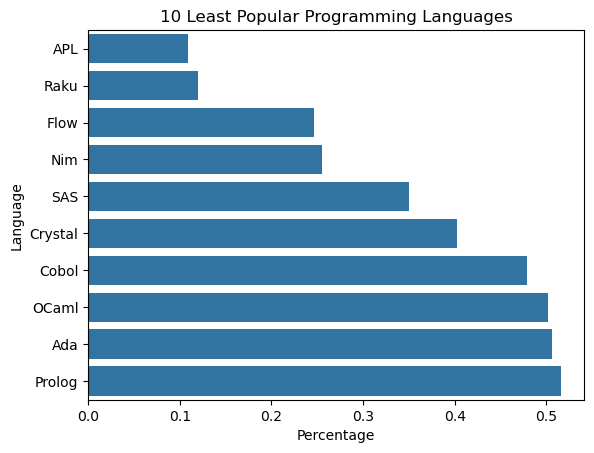

In [18]:
sns.barplot(data=userProportions.sort_values('Percentage')[:10], y='Language', x='Percentage', color=color)
plt.title('10 Least Popular Programming Languages')
plt.show()

The most popular language is JavaScript with about 65% of respondents say they know it followed by HTML/CSS and SQL. The least popular language is APL with only 0.1% of individuals knowing it, followed by Raku and Flow.

In [19]:
topNames = (userProportions[:15]['Language']).to_numpy()
topLanguages = languages[topNames]
topLanguages.head()

,JavaScript,HTML/CSS,SQL,TypeScript,Python,Bash/Shell (all shells),C#,Java,PHP,C++,Go,PowerShell,C,Rust,Kotlin
0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0


Looking at the most popular languages, we can see that there might be a high correlation between knowing certain languages like JavaScript and HTML/CSS since they are used together frequently. We can plot the correlations of the top 15 languages to look at which ones are highly correlated.

<Figure size 1000x1000 with 0 Axes>

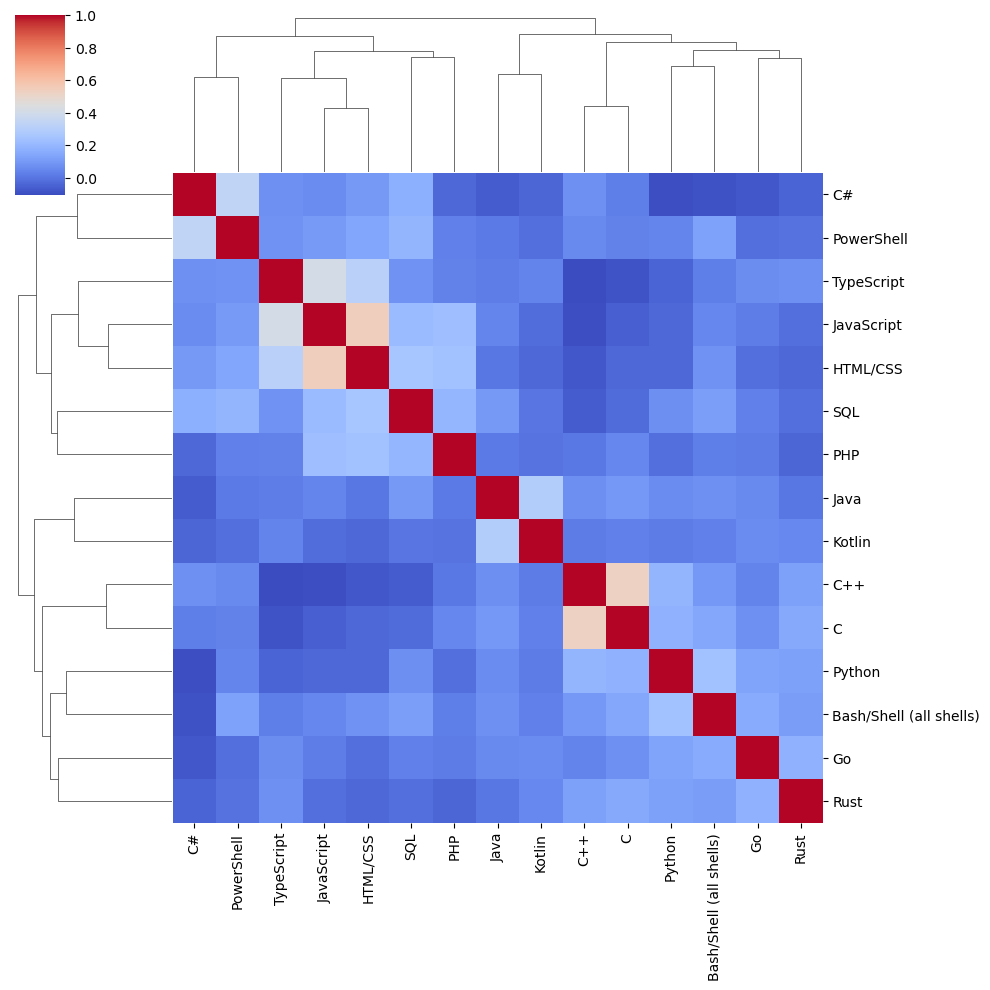

In [20]:
correlation_matrix = topLanguages.corr()
plt.figure(figsize=(10, 10))
sns.clustermap(correlation_matrix, cmap="coolwarm")
plt.show()

Using the cluster map, we can see that certain groups of languages are likely to be known together, like JavaScript and HTML/CSS, C++ and C, or Java and Kotlin. These groupings make sense because it is likely that people would learn these languages and use them together.

### Bivariate Analysis of Language Count and Median Salary

In [21]:
Total_Languages_Count.index

Int64Index([4, 5, 3, 6, 2, 7, 8, 1, 9, 10, 11, 12, 13, 14, 15, 16, 18, 17, 20,
            19],
           dtype='int64')

We first create a scatter plot to get an idea of how the number of the software engineers possessing each language and their median salaries look like.

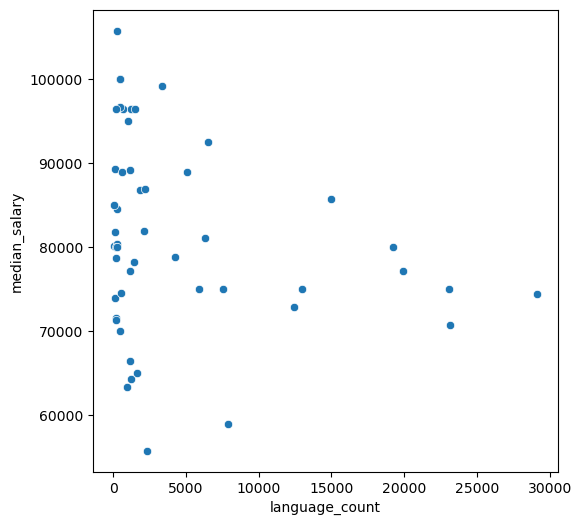

In [22]:
data1 = []#create a empty list

for program_language in data.columns[2:]:#selecting the columns starting from the column with index 2, in this case, the specific language starts from index 2.
    each_language_count = data[program_language].sum()#number counts for each language
    median_salary = data[data[program_language] == 1]['Salary'].median()#median salary for each language, the reason for '==1' is due to we have implemented one-hold encoding to the existing dataset, '==1' indicates the people that have used the specific languages.
    data1.append([program_language, each_language_count, median_salary])
df1 = pd.DataFrame(data1, columns=['Languages', 'language_count', 'median_salary'])#create a dataframe for plotting.

plt.figure(figsize=(6, 6))
sns.scatterplot(x='language_count', y='median_salary', data=df1)
plt.show()

In [23]:
medians = {}
means = {}
for l in Total_Languages_Count.index:
    selected_lines = data_no_outlier[data_no_outlier['Total_Languages']==l]
    median_salary = selected_lines['Salary'].median()
    medians[l] = median_salary
    means[l] = selected_lines['Salary'].mean()

We calculate the median salary for each number of total languages possessed, and store the information in a dictionary called medians.

We then visualize the relationship between median salariy and total languages by a line plot.

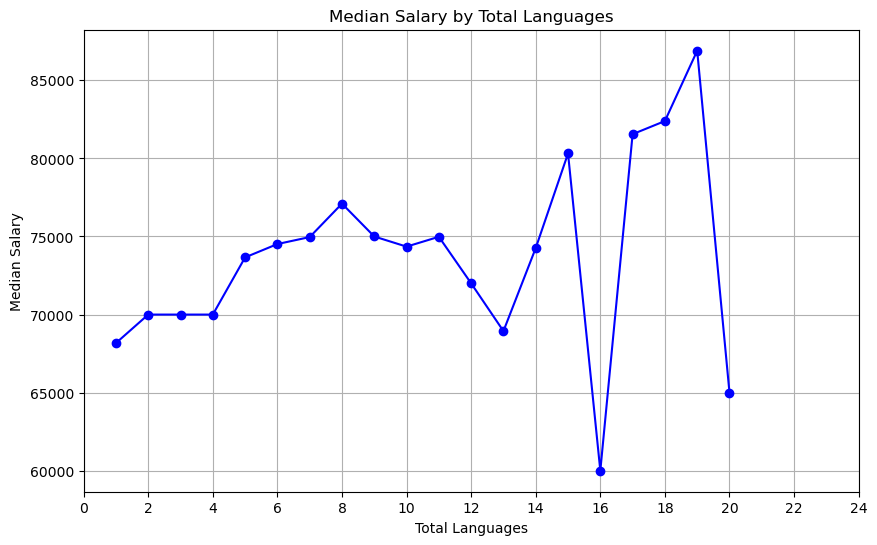

In [24]:
medians_df = pd.DataFrame(list(medians.items()), columns=['Total_Languages', 'Median_Salary'])
medians_df = medians_df.sort_values(by='Total_Languages')
plt.figure(figsize=(10, 6))
plt.plot(medians_df['Total_Languages'], medians_df['Median_Salary'], marker='o', linestyle='-', color='b')

plt.title('Median Salary by Total Languages')
plt.xlabel('Total Languages')
plt.ylabel('Median Salary')
plt.xticks(np.arange(0,25,step=2))
plt.grid(True)
plt.show()

From the graph, we could observe a rising trend in median salary overall as total languages possessed increases. The increase is most significant when the total languages increase from 4 to 5. After the number of languages get pass 10, there is significant fluctuation in the median salary, which might be attributed to the lack of samples (not a lot of software engineers possess so many languages).


## Relationship Analysis (Salaries and Total Number of Languages)

In this section, we are going to explore the relationship between median salaries and the number of languages one poccesses further. First, we apply polynomial fitting on medians_df, the dataframe we created in the last section, to capture the nonlinear relationship between the two variables.

In [25]:
x0 = medians_df['Total_Languages']
y0 = medians_df['Median_Salary']

In [26]:
outcome, predictors = patsy.dmatrices('Salary ~ Total_Languages',data_no_outlier)
mod = sm.OLS(outcome, predictors)
res_1 = mod.fit() 

In [27]:
coefficients = np.polyfit(x0, y0, 3)  # Fit a third-degree polynomial
p = np.poly1d(coefficients)  # Create a polynomial function
# Generate data points for the fitted curve
x_fit0 = np.linspace(min(x0), max(x0), 100)  # Generate evenly spaced x values
y_fit0 = p(x_fit0)

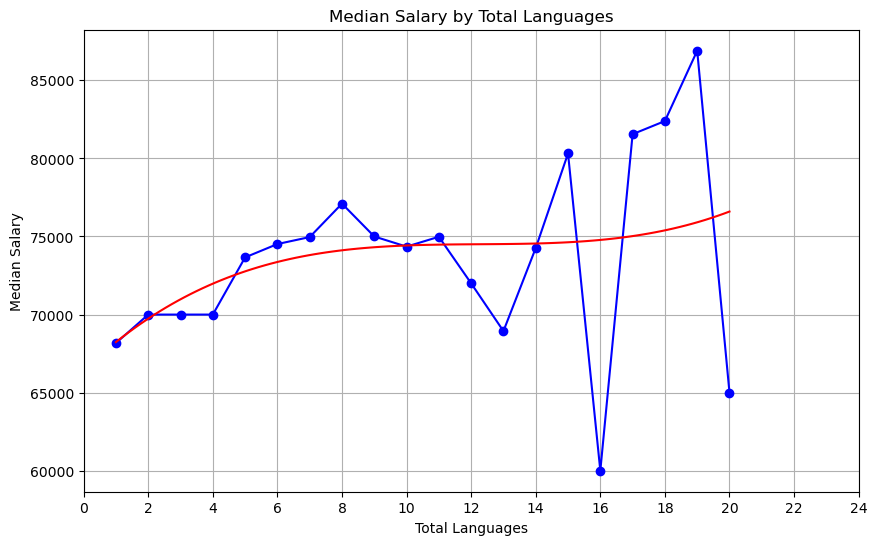

In [28]:
medians_df = pd.DataFrame(list(medians.items()), columns=['Total_Languages', 'Median_Salary'])
medians_df = medians_df.sort_values(by='Total_Languages')
plt.figure(figsize=(10, 6))
plt.plot(medians_df['Total_Languages'], medians_df['Median_Salary'], marker='o', linestyle='-', color='b')
plt.plot(x_fit0,y_fit0,color='red', label='Fitted line')
plt.title('Median Salary by Total Languages')
plt.xlabel('Total Languages')
plt.ylabel('Median Salary')
plt.xticks(np.arange(0,25,step=2))
plt.grid(True)
plt.show()

The fitted curve is very informative. We observe a sharp increase before the independent variable reaches 4, but the increase gradually tapered as total languages continued to increase.

However, we are aware of the drawnbacks of polynomial fitting. There's a possibility of overfitting the data, even if we chose a rather small degree of 3. The turbulence the graph exhibits with large number of languages is also problematic. This means that our result might not be conclusive across the entire x axis. 

Thus, we are going to leave our conclusions drawn from median salary calculations for now, and attempt a new approach. We decided to fit our original data with the OLS model, and see what insight it brings.

In [29]:
outcome, predictors = patsy.dmatrices('Salary ~ Total_Languages',data_no_outlier)
mod = sm.OLS(outcome, predictors)
res_1 = mod.fit()

In [30]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     86.70
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           1.32e-20
Time:                        20:10:16   Log-Likelihood:            -5.1924e+05
No. Observations:               42220   AIC:                         1.038e+06
Df Residuals:                   42218   BIC:                         1.039e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         7.73e+04    534.731    1

The two variables have a extremely weak correlation according to a R-squared value of 0.002. However, this occurs probably due to the different scales between our two variables. For example, an increase in salary from 70000 to 75000 is actually quite significant. 

We look closely at our coefficients. It's indicated that a unit increase in total languages leads to an increase of $845.56 in salaries, which is indeed weak. We want to rule out the influence of turbulence, caused by limited samples with large values of the independent variable. In the next fitting attempt, we only keep entries with total languages fewer than 10.

In [31]:
outcome, predictors = patsy.dmatrices('Salary ~ Total_Languages', data_no_outlier[data_no_outlier['Total_Languages'] < 10])
mod = sm.OLS(outcome, predictors)
res_2 = mod.fit()

In [32]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     139.2
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           4.62e-32
Time:                        20:10:16   Log-Likelihood:            -4.8335e+05
No. Observations:               39314   AIC:                         9.667e+05
Df Residuals:                   39312   BIC:                         9.667e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        7.448e+04    653.268    1

In this attempt, we reaches a higher R-squared of 0.004, and an intercept of $1512.45. 

We are able to conclude overall that there's a weak positive correlation between median salaries of software engineers and total number of languages they poccess. The rate of increase diminishes as the independent variable gets larger. 

## Relationship Analysis (Median Salaries and Popularity of the Programing Languages)

In [33]:
language_popularity = languages.sum().sort_values(ascending=False)#use sort_values function and by setting the parameter ascending = False, we could obtain the popularity order of the programming languages.

median_salaries = {}
for language in languages.columns:
    median_salaries[language] = data[data[language] == 1]['Salary'].median()#calculate the median salaries.

median_salaries_df = pd.DataFrame(median_salaries.items(), columns=['Language', 'MedianSalary'])#convert median salaries to a dataframe.
popularity_salary_df = median_salaries_df.merge(language_popularity.rename('Popularity'), left_on='Language', right_index=True)#merge the median salaries dataframe with popularity which is obtained above.
popularity_salary_df.head()

,Language,MedianSalary,Popularity
0,APL,80092.0,48
1,Ada,71502.0,224
2,Apex,80317.0,269
3,Assembly,78207.0,1405
4,Bash/Shell (all shells),85672.0,14999


### First Analysis

In [34]:
import patsy
import statsmodels.api as sm
outcome, predictors = patsy.dmatrices('MedianSalary ~ Popularity', popularity_salary_df)

mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           MedianSalary   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.895
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0952
Time:                        20:10:16   Log-Likelihood:                -547.05
No. Observations:                  51   AIC:                             1098.
Df Residuals:                      49   BIC:                             1102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.303e+04   1867.822     44.454      0.0

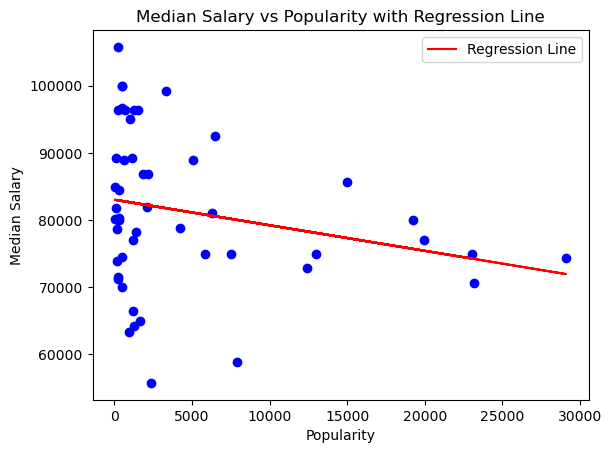

In [35]:
plt.scatter(popularity_salary_df['Popularity'], popularity_salary_df['MedianSalary'], color='blue')#plot the relationship between popularity of the programming languages and the median salary.

predicted_salary = res.predict(predictors)
plt.plot(popularity_salary_df['Popularity'], predicted_salary, color='red', label='Regression Line')#this is used to obtain the regression line.

plt.xlabel('Popularity')
plt.ylabel('Median Salary')
plt.title('Median Salary vs Popularity with Regression Line')

plt.legend()
plt.show()                

### Result

According to the OLS analysis, the R-squared value is 0.056 which is considered relatively low. This means that only 5.6% of the change in median salary is explained by the popularity of programming languages. The coefficient of -0.3806 indicates that the popularity of programming languages  and median salary have a negative relationship. We also obtain a p-value of 0.095 which is larger than the threshold of 0.05, indicating that popularity is not statistically significant. In addition, the condition number is large which indicates that there could be strong multicollinearity. Based on the summary, we can conclude that the correlation between popularity of programming languages and median salary is weak. We will try to transform the data in the following cells in order to see if further observations would change the conclusion.

### Second Analysis (With Polynomial Transformation)

In [36]:
popularity_salary_df['Popularity_Squared'] = popularity_salary_df['Popularity'] ** 2
popularity_salary_df['Popularity_Cubed'] = popularity_salary_df['Popularity'] ** 3
outcome1, predictors1 = patsy.dmatrices('MedianSalary ~ Popularity + Popularity_Squared + Popularity_Cubed', popularity_salary_df)

mod1 = sm.OLS(outcome1, predictors1)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:           MedianSalary   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.087
Date:                Wed, 20 Dec 2023   Prob (F-statistic):              0.364
Time:                        20:10:16   Log-Likelihood:                -546.81
No. Observations:                  51   AIC:                             1102.
Df Residuals:                      47   BIC:                             1109.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           8.407e+04   2447

### Result

We implemented polynomial transformation in our second analysis. By observing the summary, we obtain an R-squared value of 0.065 which is higher than the previous analysis (0.056). This indicates that 6.5% of the change in the median salary could be explained by the popularity of programming languages. However, this R-squared value is still relatively low. In addition, the p-values for transformed popularity variables (popularity, popularity squared, popularity_cubed) which are 0.390, 0.602, 0.674 respectively, are still higher than the threshold of 0.05, indicating that popularity is not statistially significant. The condition number is also still large meaning there might be strong multicollinearity. In conclusion, even though we implemented polynomial transformation on popularity of programming languages, the result indicates that popularity of programming languages alone is not significant enough to explain the change in median salaries. The correlation between the popularity of programming languages and median salaries are still weak after the transformation.

### Third Analysis (With Logarithmic Transformation)

In [37]:
popularity_salary_df['Log_Popularity'] = np.log(popularity_salary_df['Popularity'])
outcome2, predictors2 = patsy.dmatrices('MedianSalary ~ Log_Popularity', popularity_salary_df)

mod2 = sm.OLS(outcome2, predictors2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:           MedianSalary   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.761
Date:                Wed, 20 Dec 2023   Prob (F-statistic):              0.103
Time:                        20:10:16   Log-Likelihood:                -547.12
No. Observations:                  51   AIC:                             1098.
Df Residuals:                      49   BIC:                             1102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        9.24e+04   6852.104     13.

### Result

Since logarithm is always a powerful tool in data transformation in terms of non-linear correlation, we tried to implement logarithmic transformation on the popularity of programming languages to see if different results would occur. However, based on the summary, the R-squared obtained is 0.053 which is lower than the R-squared in the first analysis (0.056). This R-squared value is quite low, indicating that only 5.3% of the change in median salary could be explained by the popularity of programming languages. We also obtained a p-value of 0.103 which is a little higher than the p-value in the first analysis, indicating that popularity is not statistically significant. Overall, the correlation between popularity of programming languages and median salary is still weak after logarithmic transformation.

### Fourth Analysis (Salary Prediction)

In [38]:
data2 = data.copy()
data2.columns = pd.Series(data2.columns).str.replace(r'[ \(\)\.\/\-]', '', regex=True).str.replace('#', '_sharp')
all_columns = "+".join(data2.drop(columns=['Salary', 'Total_Languages']).columns)
formula = "Salary ~" + all_columns
outcome3, predictors3 = patsy.dmatrices(formula, data2)
mod3 = sm.OLS(outcome3, predictors3)
res3 = mod3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     37.57
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:10:17   Log-Likelihood:            -6.5761e+05
No. Observations:               44245   AIC:                         1.315e+06
Df Residuals:                   44194   BIC:                         1.316e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            9.03e+04   7750

### Result

We want to predict a software engineer's salary based on the number of programming languages they know and specifically which ones they know. This is so that we can estimate our own salaries in the future and see if we should learn a different language if we want to increase it. Based on the prediction results from the OLS analysis, Ada, Delphi, F_sharp, Apex, and Cobol are the top 5 languages that are postively associated with the median salaries, meaning that learning these 5 languages are potentially more beneficial to the individuals. However, it is also important to notice that Apex and F_sharp have P-values that are higher than the 0.05 threshold, meaning the results for these two programming languages are not statistically significant. Therefore, the results for F_sharp and Apex might not be valid.

### Conclusion

Based on our summaries, Ada, Delphi, and Cobol are potentially the most beneficial languages to future career for students majoring in computer science. In addition, it is safe to say that the correlation between median salaries and popularity of programming languages is relatively weak, and more importantly, the popularity of programming languages alone is not significant enough to explain the change in median salaries.

## Prediction Model

We want to predict a software engineer's salary based on the number of programming languages they know and specifically which ones they know. This is so that we can estimate our own salaries in the future and see if we should learn a different language if we want to increase it.

### Baseline Model

First we should come up with a baseline model and do a simple prediction to determine the Root Mean Squared Error (RMSE). Then we can make more complicated models and compare their RMSEs with the baseline to get a sense of how much they are improved. To start, we should split our data into a train and test set.

In [39]:
features = data.iloc[:, 2:]
salary = data['Salary']
X_train, X_test, y_train, y_test = train_test_split(features, salary, test_size=0.2)

Now we can train a linear regression model on our training dataset. 

In [40]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print()

We then define a function that can find the RMSE between our predictions and the actual salary values. Using this, we can find the RMSE of our linear regressor on the test set.

In [41]:
def RMSE(predictions, actual):
    return np.sqrt(np.mean((predictions - actual)**2))

predictions = linreg.predict(X_test)
linreg_RMSE = RMSE(predictions, y_test)
print(f'RMSE: {linreg_RMSE}')

RMSE: 670034.8535665086


### Random Forest Model

We can use a random forest regressor to try and improve on the linear regressor by getting a better RMSE. We decided to use a random forest because we thought decision trees would easily be able to make decisions if all of the data was binary. We can train the forest with the same training data as the linear regressor. The we can predict on the test set and find the RMSE.

In [42]:
np.random.seed(1)
forest = RandomForestRegressor(n_jobs=8)
forest.fit(X_train, y_train)
preds = forest.predict(X_test)
forest_RMSE = RMSE(preds, y_test)
print(f'RMSE: {forest_RMSE}')

RMSE: 863279.9685353034


This is the difference between the baseline RMSE and our new model's RMSE.

In [43]:
print(f'Difference in RMSE: {linreg_RMSE - forest_RMSE}')

Difference in RMSE: -193245.11496879475


The RMSE of the forest is higher than the linear regressor right now because it is overfitting too much to the training data. We need to do hyperparameter tuning for things like tree depth and number of leaf samples to get a better performance. We can use grid search cross validation to do our tuning by testing every hyperparameter combination on multiple validation sets.

First, we can plot the trends of the RMSE as it varies with each hyperparameter using the results of the grid search. We can use this to show the results of the tuning and which hyperparameter values to choose for the final model.

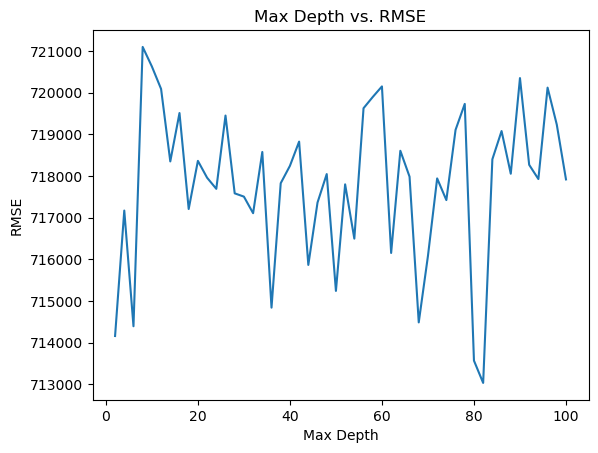

In [44]:
np.random.seed(1)
params_md = {'max_depth':np.arange(2, 102, 2),
         'n_estimators':[3],
         'min_samples_split':[500],
         'min_samples_leaf':[25]}
cv_md = GridSearchCV(RandomForestRegressor(), param_grid=params_md, n_jobs=8, cv=8, scoring='neg_mean_squared_error')
cv_md.fit(X_train, y_train)
results_md = pd.DataFrame(cv_md.cv_results_)
error_md = np.sqrt(results_md.groupby('param_max_depth')['mean_test_score'].mean()*-1)
plt.plot(error_md)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Max Depth vs. RMSE')
plt.show()

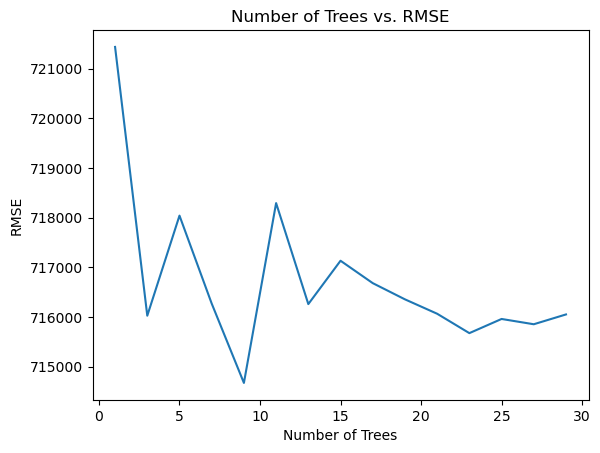

In [45]:
np.random.seed(1)
params_ne = {'max_depth':[16],
         'n_estimators':np.arange(1, 30, 2),
         'min_samples_split':[500],
         'min_samples_leaf':[25]}
cv_ne = GridSearchCV(RandomForestRegressor(), param_grid=params_ne, n_jobs=8, cv=8, scoring='neg_mean_squared_error')
cv_ne.fit(X_train, y_train)
results_ne = pd.DataFrame(cv_ne.cv_results_)
error_ne = np.sqrt(results_ne.groupby('param_n_estimators')['mean_test_score'].mean()*-1)
plt.plot(error_ne)
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Number of Trees vs. RMSE')
plt.show()

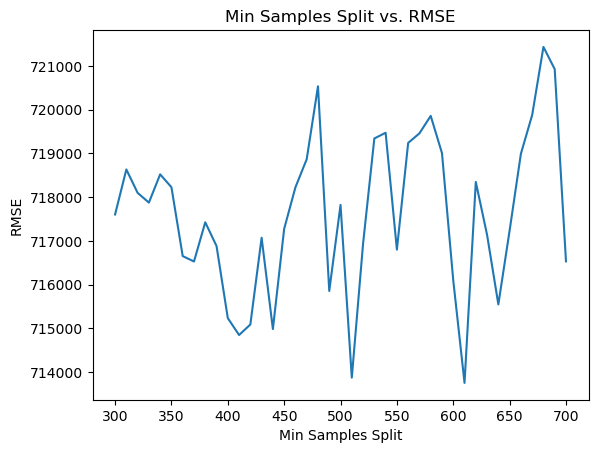

In [46]:
np.random.seed(1)
params_mss = {'max_depth':[16],
         'n_estimators':[3],
         'min_samples_split':np.arange(300, 701, 10),
         'min_samples_leaf':[25]}
cv_mss = GridSearchCV(RandomForestRegressor(), param_grid=params_mss, n_jobs=8, cv=8, scoring='neg_mean_squared_error')
cv_mss.fit(X_train, y_train)
results_mss = pd.DataFrame(cv_mss.cv_results_)
error_mss = np.sqrt(results_mss.groupby('param_min_samples_split')['mean_test_score'].mean()*-1)
plt.plot(error_mss)
plt.xlabel('Min Samples Split')
plt.ylabel('RMSE')
plt.title('Min Samples Split vs. RMSE')
plt.show()

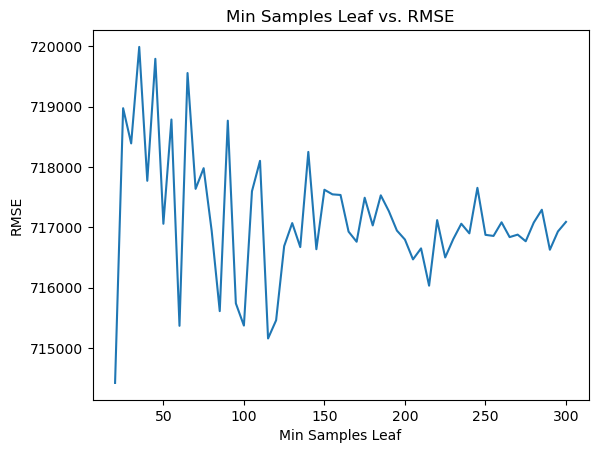

In [47]:
np.random.seed(1)
params_msl = {'max_depth':[16],
         'n_estimators':[3],
         'min_samples_split':[500],
         'min_samples_leaf':np.arange(20, 301, 5)}
cv_msl = GridSearchCV(RandomForestRegressor(), param_grid=params_msl, n_jobs=8, cv=8, scoring='neg_mean_squared_error')
cv_msl.fit(X_train, y_train)
results_msl = pd.DataFrame(cv_msl.cv_results_)
error_msl = np.sqrt(results_msl.groupby('param_min_samples_leaf')['mean_test_score'].mean()*-1)
plt.plot(error_msl)
plt.xlabel('Min Samples Leaf')
plt.ylabel('RMSE')
plt.title('Min Samples Leaf vs. RMSE')
plt.show()

Now we can try combinations of hyperparameters to find the best perfoming model with grid search cross validation. We can use the plots above to estimate what range of parameters we should be checking.

In [48]:
np.random.seed(1)
params = {'max_depth':[10, 15, 20, 25, 30],
         'n_estimators':[1, 2, 3, 4, 5],
         'min_samples_split':[300, 400, 500, 600, 700],
         'min_samples_leaf':[25, 50, 75, 100, 125]}
cv = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=8, cv=3, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)
print()

The best combination of hyperparameters from the tuning after cross validation are

|hyperparameter|value|
|---|---|
|max_depth|25|
|n_estimators|2|
|min_samples_split|400|
|min_samples_leaf|25|

We can now use this tuned model to get the RMSE on the test set.

In [49]:
np.random.seed(1)
tuned_forest = RandomForestRegressor(n_jobs=8, max_depth=25, n_estimators=2, min_samples_split=400, min_samples_leaf=25)
tuned_forest.fit(X_train, y_train)
preds = tuned_forest.predict(X_test)
tuned_RMSE = RMSE(preds, y_test)
print(f'RMSE: {(tuned_RMSE)}')

RMSE: 650162.1348037618


We can see that our new tuned forest performs much better than the untuned forest because it has a lower MSE.

In [50]:
print(f'Difference between untuned and tuned models: {(forest_RMSE - tuned_RMSE)}')

Difference between untuned and tuned models: 213117.83373154153


Our tuned forest also now performs much better than the linear regression baseline.

In [51]:
print(f'Difference between linear and random forest regression: {(linreg_RMSE - tuned_RMSE)}')

Difference between linear and random forest regression: 19872.71876274678


## Programming Language Recommender

We also want to find out what languages we should learn next to try to get a better salary. We know from our EDA that software engineers learn certain languages together, because they can be used together in many ways like JavaScript and HTML/CSS. We can use the groups of languages that people already know to recommend a person a new language that works well with the ones they already know, making them more adaptable and therefore likely to get a higher salary. We can start by finding the cosine similarity between users' known languages in the dataset.

In [52]:
user_item_matrix = csr_matrix(features[:5000])
cosine_sim_matrix = cosine_similarity(user_item_matrix, user_item_matrix)

We can choose a certain software engineer and see what programming languages they know. 

In [53]:
user_id = 15
known = features.iloc[user_id][features.iloc[user_id] == 1].index
print('Known Languages:')
for i in known:
    print(i)

Known Languages:
JavaScript
PHP
Ruby
TypeScript


We can use the cosine similarities between known programming languages to find the software engineers who have the closest skill set to the given engineer. These are the rows which contain the most similar software engineers.

In [54]:
user_vector = user_item_matrix[user_id]
similarities = cosine_sim_matrix[user_id]
sorted_indices = np.argsort(similarities)[::-1]
close_users = [i for i in sorted_indices if (user_item_matrix[i].toarray() != user_vector).any()]
close_users[:10]

[291, 495, 2404, 100, 3821, 2899, 457, 4182, 4071, 3765]

We can find out what languages the similar engineers know that our given user doesn't, to make recommendations. We can take the top 3 languages as ones that the given engineer can learn to improve their skills.

In [55]:
unseen_items = []
for i in sorted_indices:  
    for j in range(user_vector.shape[1]):
        if ((user_item_matrix[i].toarray()[0][j] == 1) & (user_vector.toarray()[0][j] == 0) & (j not in unseen_items)):
            unseen_items.append(j)
    
    if len(unseen_items) > 3:
        break

top_n = 3
recommendations = features.columns[unseen_items[:top_n]]
print('Languages Recommended to Learn:')
for i in recommendations:
    print(i)

Languages Recommended to Learn:
HTML/CSS
SQL
Python


The model recommends HTML/CSS to someone who knows JavaScript which makes sense because they can be used together for front end development, giving the software engineer another skill. It also makes sense to recommend SQL and Python because they are very common languages that can be used for a lot of things. The model helps determine the most efficient way to increase one's salary because it shows the most important languages to learn to be competitive against other software engineers.

## Conclusion

As graduating students majoring in STEM fields ourselves, poised to begin our job search in the near future, this study was initiated from our own experiences. We are glad to have had the opportunity to delve into the topic of how proficiency in multiple programming languages impacts employment opportunities and salary scales. Our analysis aimed to provide insights that are expected to be valuable for individuals looking to enhance their career prospects in this competitive job market.

Our dataset comprises 89,184 observations and 79 columns, each corresponding to a person's job in the tech industry. The dataset underwent cleaning, isolating the salary as our dependent variable and the programming languages used in the job as our independent variable. To handle the language data condensed into lists, we utilized one-hot encoding. Key findings from the salary analysis reveal a mean of \\$103,622.10, a standard deviation of \\$704,169.70, a minimum value of \\$1, and a maximum value of \\$74 million. Regarding programming languages, the mean count of languages used is 5.18, with a minimum count of 1 and a maximum count of 51. Our analysis also revealed the prevalence of popular languages such as HTML, CSS, Javascript, and Python, which were used by a large majority of the respondents, reflecting the popularity of these languages.

We also conducted exploratory data analysis which encompass univariate and bivariate analyses to get a better understanding of the data. The univariate analysis of salaries indicates a right-skewed distribution which suggests that a majority of individuals earn salaries within the lower bracket. Conversely, the univariate analysis of programming languages reveals a roughly normal distribution which is centered around 5 languages. This aligns with the expectation that individuals typically work with a limited number of programming languages. Furthermore, the bivariate analysis of user per language identifies JavaScript as the most popular language that is adopted by approximately 65% of respondents, and is followed closely by HTML/CSS and SQL. These languages commonly come together as individuals often learn and utilize them together. Additionally, a bivariate analysis of language count against median salary reveals a rising trend in median salary as the total number of languages increases. Notably, a significant rise occurs when the count increases from 4 to 5 languages. However, after surpassing 10 languages, the median salary tends to fluctuate due to the limited number of samples available.

In the analysis section, we used polynomial fitting to generate a smoothed curve from our graph in the previous section, attempting to draw more conclusions from the observed trend. Using a degree of three, the fitted curve displayed a gradually tapered increase of median salary as total languages increase. However, we are aware of the drawbacks of polynomial fitting, so we turn back to our original dataset and perform regression with the OLS model. Our result showed that an unit increase in the independent variable only leads to a \\$845.56 increase in salary, the R-squared value is also very small, indicating weak or no correlation. We are aware that the lack of samples that possess a large number of languages might interfere with the result. We redo the OLS analysis, this time limiting total languages to be less than 10. Now an unit increase of the independent variable leads to a \\$1512.45. The r-squared value is still small, but it might be due to the lack of standardized measures used, which is one potential area of improvement. The result shows weak correlation between our two variables of interest. We formulate that programmers with a diverse skill set demonstrate great learning ability, however, since most companies operate in a limited range of languages, their abilities aren’t fully converted to an advantage against peers. 

In addition to exploring the correlation between the number of total languages and median salary, we are also interested in exploring the correlation between the popularity of the languages and the median salary. First, we discovered the popularity of the languages within the dataset, then we combined this with the column containing median salary into a new dataframe. Then we implemented OLS analysis and also plotted the regression line in order to show the general trend of the regression line in order to determine the correlation. According to the coefficient the summary displayed and the regression line’s direction, we discovered that the popularity and the median salary tend to have a negative correlation, meaning that the higher the popularity of the language, the lower the median salary one individual is likely to obtain. However, it is essential to recognize that the P-value is higher than the threshold of 0.05, which indicates that the result is not statistically significant, and also according to the R-squared value, only approximately 5 percent of the variation in median salary could be explained by the popularity of the data. Due to these drawbacks, we then implemented various data transformations on the popularity data, including log transformation and polynomial transformation. However, the results are similar, indicating that popularity and median salary have weak correlation and popularity alone is not sufficient enough to evaluate the change in median salary. Lastly, we implemented OLS analysis to predict the salary based on the language they know, we discovered that  Ada, Delphi, F_sharp, Apex, and Cobol are 5 most beneficial languages for students to learn, this is based on the coefficients of individual languages, higher coefficients indicate potential higher median salary. However, Apex and F_sharp have P-value larger than 0.05, which indicates that the results for these two languages are not statistically significant, so we decided that only Ada, Delphi, and Cobol are the most beneficial languages to the future career.

Another thing we wanted to do with this project is to try to predict what salary a software engineer would have given the programming languages that they know. We came up with a random forest model and tuned it to get as low of an error as possible to make the best predictions for salary. In order to help future programmers who might want a higher salary than our model predicts, we also made a model using cosine similarities to recommend the best new programming languages to learn. Our work is impactful to the next generation of software engineers because it gives them a guide on which programming languages they should study to succeed in their career, and influences companies to work in languages that many programmers know.